# Aggregate metrics from `outputs`

Reads every prediction CSV under each model folder in `outputs/` and reports the mean ± standard deviation for the classification report metrics, One-vs-Rest AUC, and a row-normalized confusion matrix.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from IPython.display import display, Markdown
# Project paths and label mapping
base_dir = Path("outputs")
label_map = {0: "negative", 1: "neutral", 2: "positive"}
class_order = list(label_map.keys())
class_names = [label_map[i] for i in class_order]
model_name_map = {"bert": "BERT", "lstm": "LSTM", "naive-bayes": "Naive Bayes"}
model_order_lr = ["naive-bayes", "lstm", "bert"]
model_order_tb = ["bert", "lstm", "naive-bayes"]


In [2]:

# Helpers for formatting and aggregation

def format_mean_std(mean: float, std: float) -> str:
    std = 0.0 if pd.isna(std) else std
    return f"{mean:.4f} ± {std:.4f}"

def load_runs(model_path: Path):
    runs = []
    for fp in sorted(model_path.glob("*.csv")):
        df = pd.read_csv(fp)
        if not {"true_label", "pred_label"}.issubset(df.columns):
            print(f"Skipping {fp.name} because it lacks true_label/pred_label.")
            continue
        y_true = df["true_label"].astype(int)
        y_pred = df["pred_label"].astype(int)
        prob_cols = [f"prob_{i}" for i in class_order]
        probs = df[prob_cols].values if all(col in df.columns for col in prob_cols) else None
        runs.append({"file": fp.name, "y_true": y_true, "y_pred": y_pred, "probs": probs})
    return runs

def aggregate_classification_report(runs):
    reports = []
    for run in runs:
        report = classification_report(
            run["y_true"],
            run["y_pred"],
            target_names=class_names,
            output_dict=True,
            zero_division=0,
        )
        reports.append(pd.DataFrame(report).T)
    stacked = pd.concat(reports, keys=range(len(reports)), names=["run"])
    stats = stacked.groupby(level=1).agg(["mean", "std"])
    formatted = pd.DataFrame(index=stats.index)
    for col in stats.columns.levels[0]:
        formatted[col] = stats[col].apply(lambda r: format_mean_std(r["mean"], r["std"]), axis=1)
    return formatted

def aggregate_auc(runs):
    prob_runs = [run for run in runs if run["probs"] is not None]
    if not prob_runs:
        return None
    auc_rows = []
    for run in prob_runs:
        y_true_bin = label_binarize(run["y_true"], classes=class_order)
        auc_rows.append({
            class_names[i]: roc_auc_score(y_true_bin[:, i], run["probs"][:, i])
            for i in range(len(class_order))
        })
    df = pd.DataFrame(auc_rows)
    summary = pd.DataFrame(index=df.columns)
    summary["ovr_auc"] = [format_mean_std(df[col].mean(), df[col].std(ddof=0)) for col in df.columns]
    return summary

def aggregate_macro_auc(runs):
    prob_runs = [r for r in runs if r["probs"] is not None]
    if not prob_runs:
        return None

    rows = []
    for run in prob_runs:
        y_true_bin = label_binarize(run["y_true"], classes=class_order)
        try:
            macro_auc = roc_auc_score(y_true_bin, run["probs"], average="macro")
        except ValueError:
            macro_auc = np.nan
        rows.append({"run": run["file"], "macro_auc": macro_auc})

    df = pd.DataFrame(rows)
    summary = pd.DataFrame(
        {"macro_auc": [format_mean_std(df["macro_auc"].mean(), df["macro_auc"].std(ddof=0))]},
        index=["mean ± std"],
    )
    return df, summary


def aggregate_confusion(runs):
    matrices = []
    for run in runs:
        cm = confusion_matrix(run["y_true"], run["y_pred"], labels=class_order)
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        matrices.append(cm / row_sums)
    cube = np.stack(matrices)
    mean = cube.mean(axis=0)
    std = cube.std(axis=0)
    data = []
    for i, cname in enumerate(class_names):
        row = {}
        for j, pred in enumerate(class_names):
            row[pred] = format_mean_std(mean[i, j], std[i, j])
        data.append(row)
    return pd.DataFrame(data, index=class_names)


In [3]:

# Evaluate every model folder under outputs/
model_dirs = sorted([p for p in base_dir.iterdir() if p.is_dir()], reverse=True)
if not model_dirs:
    raise ValueError("No model directories found in outputs/.")

for model_dir in model_dirs:
    runs = load_runs(model_dir)
    if not runs:
        display(Markdown(f"### {model_dir.name} (no runs found)"))
        continue

    display(Markdown(f"## {model_dir.name} ({len(runs)} run(s))"))

    display(Markdown("**Classification report (mean ± std)**"))
    display(aggregate_classification_report(runs))

    auc_table = aggregate_auc(runs)
    if auc_table is not None:
        display(Markdown("**One-vs-Rest AUC (mean ± std)**"))
        display(auc_table)
    else:
        display(Markdown("**One-vs-Rest AUC:** skipped because no probability columns were found."))
        
    macro_runs, macro_summary = aggregate_macro_auc(runs) if runs else (None, None)
    if macro_runs is None:
        display(Markdown("**Macro AUC:** skipped because no probability columns."))
    else:
        display(Markdown("**Macro AUC (mean ± std over runs)**"))
        display(macro_summary)


    display(Markdown("**Row-normalized confusion matrix (mean ± std)**"))
    display(aggregate_confusion(runs))


## naive-bayes (10 run(s))

**Classification report (mean ± std)**

,precision,recall,f1-score,support
accuracy,0.7030 ± 0.0023,0.7030 ± 0.0023,0.7030 ± 0.0023,0.7030 ± 0.0023
macro avg,0.6240 ± 0.0042,0.6540 ± 0.0055,0.6182 ± 0.0033,3673.0000 ± 0.0000
negative,0.3953 ± 0.0086,0.7101 ± 0.0218,0.5076 ± 0.0067,467.0000 ± 0.0000
neutral,0.6345 ± 0.0135,0.4461 ± 0.0233,0.5233 ± 0.0126,925.0000 ± 0.0000
positive,0.8424 ± 0.0101,0.8058 ± 0.0095,0.8236 ± 0.0022,2281.0000 ± 0.0000
weighted avg,0.7332 ± 0.0054,0.7030 ± 0.0023,0.7078 ± 0.0028,3673.0000 ± 0.0000


**One-vs-Rest AUC (mean ± std)**

,ovr_auc
negative,0.8654 ± 0.0047
neutral,0.8214 ± 0.0037
positive,0.8698 ± 0.0041


**Macro AUC (mean ± std over runs)**

,macro_auc
mean ± std,0.8522 ± 0.0037


**Row-normalized confusion matrix (mean ± std)**

,negative,neutral,positive
negative,0.7101 ± 0.0207,0.0949 ± 0.0124,0.1951 ± 0.0120
neutral,0.2801 ± 0.0164,0.4461 ± 0.0221,0.2738 ± 0.0267
positive,0.1091 ± 0.0054,0.0851 ± 0.0079,0.8058 ± 0.0091


## lstm (10 run(s))

**Classification report (mean ± std)**

,precision,recall,f1-score,support
accuracy,0.7531 ± 0.0049,0.7531 ± 0.0049,0.7531 ± 0.0049,0.7531 ± 0.0049
macro avg,0.6715 ± 0.0049,0.7223 ± 0.0073,0.6885 ± 0.0051,3673.0000 ± 0.0000
negative,0.4908 ± 0.0127,0.6925 ± 0.0302,0.5740 ± 0.0098,467.0000 ± 0.0000
neutral,0.6014 ± 0.0163,0.6789 ± 0.0259,0.6373 ± 0.0078,925.0000 ± 0.0000
positive,0.9224 ± 0.0110,0.7955 ± 0.0130,0.8541 ± 0.0037,2281.0000 ± 0.0000
weighted avg,0.7867 ± 0.0046,0.7531 ± 0.0049,0.7639 ± 0.0040,3673.0000 ± 0.0000


**One-vs-Rest AUC (mean ± std)**

,ovr_auc
negative,0.8994 ± 0.0049
neutral,0.8678 ± 0.0031
positive,0.9140 ± 0.0017


**Macro AUC (mean ± std over runs)**

,macro_auc
mean ± std,0.8937 ± 0.0025


**Row-normalized confusion matrix (mean ± std)**

,negative,neutral,positive
negative,0.6925 ± 0.0286,0.2028 ± 0.0343,0.1047 ± 0.0215
neutral,0.2083 ± 0.0145,0.6789 ± 0.0246,0.1128 ± 0.0172
positive,0.0629 ± 0.0061,0.1416 ± 0.0103,0.7955 ± 0.0123


## bert (10 run(s))

**Classification report (mean ± std)**

,precision,recall,f1-score,support
accuracy,0.8134 ± 0.0029,0.8134 ± 0.0029,0.8134 ± 0.0029,0.8134 ± 0.0029
macro avg,0.7478 ± 0.0055,0.7751 ± 0.0031,0.7598 ± 0.0038,3673.0000 ± 0.0000
negative,0.6545 ± 0.0178,0.7328 ± 0.0160,0.6910 ± 0.0037,467.0000 ± 0.0000
neutral,0.6676 ± 0.0046,0.7279 ± 0.0179,0.6963 ± 0.0075,925.0000 ± 0.0000
positive,0.9213 ± 0.0038,0.8647 ± 0.0040,0.8921 ± 0.0017,2281.0000 ± 0.0000
weighted avg,0.8235 ± 0.0029,0.8134 ± 0.0029,0.8172 ± 0.0028,3673.0000 ± 0.0000


**One-vs-Rest AUC (mean ± std)**

,ovr_auc
negative,0.9482 ± 0.0014
neutral,0.9098 ± 0.0020
positive,0.9445 ± 0.0007


**Macro AUC (mean ± std over runs)**

,macro_auc
mean ± std,0.9342 ± 0.0009


**Row-normalized confusion matrix (mean ± std)**

,negative,neutral,positive
negative,0.7328 ± 0.0152,0.1820 ± 0.0119,0.0852 ± 0.0056
neutral,0.1329 ± 0.0145,0.7279 ± 0.0170,0.1392 ± 0.0101
positive,0.0256 ± 0.0024,0.1097 ± 0.0039,0.8647 ± 0.0038


# Charts and plots

## 1.  **Model Performance Comparison**

Compare Naive Bayes, LSTM, and BERT on overall Accuracy and F1-Score, and use error bars to show stability across different random seeds.


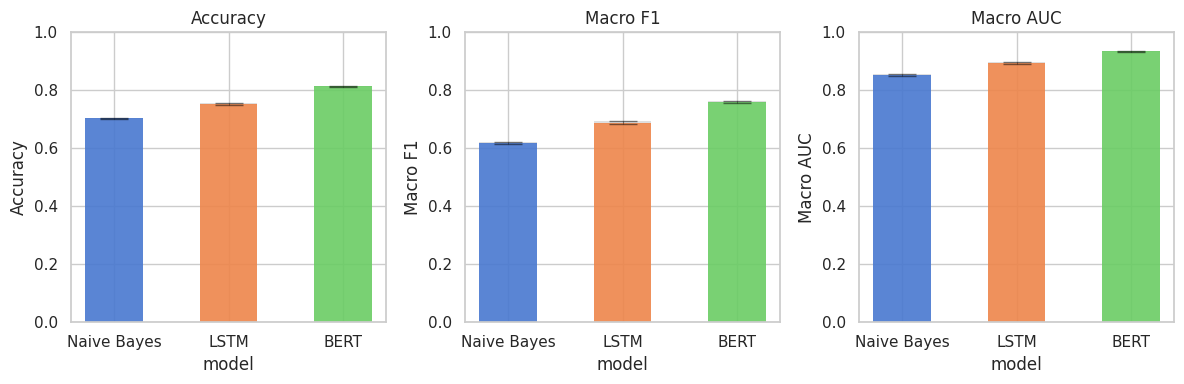

In [4]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

sns.set_context("notebook")
sns.set_style("whitegrid")

# Collect runs per model for downstream visualizations
model_runs = {p.name: load_runs(p) for p in model_dirs}
model_runs = {m: r for m, r in model_runs.items() if r}

perf_records = []
for model, runs in model_runs.items():
    for run in runs:
        macro_auc = np.nan
        if run.get("probs") is not None:
            y_true_bin = label_binarize(run["y_true"], classes=class_order)
            try:
                macro_auc = roc_auc_score(y_true_bin, run["probs"], average="macro")
            except Exception:
                macro_auc = np.nan
        perf_records.append({
            "model": model,
            "run": run["file"],
            "accuracy": accuracy_score(run["y_true"], run["y_pred"]),
            "f1_macro": f1_score(run["y_true"], run["y_pred"], average="macro", zero_division=0),
            "macro_auc": macro_auc,
        })
perf_df = pd.DataFrame(perf_records)

if perf_df.empty:
    display(Markdown("No runs available for plotting."))
else:
    agg = perf_df.groupby("model").agg({"accuracy": ["mean", "std"], "f1_macro": ["mean", "std"], "macro_auc": ["mean", "std"]})
    metrics = [("accuracy", "Accuracy"), ("f1_macro", "Macro F1"), ("macro_auc", "Macro AUC")]
    fig, axes = plt.subplots(1, len(metrics), figsize=(12, 4), sharey=False)
    axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
    model_list = [m for m in model_order_lr if m in agg.index]
    model_labels = [model_name_map.get(m, m) for m in model_list]
    palette = sns.color_palette("muted", n_colors=len(model_list))
    x_pos = np.arange(len(model_list))
    bar_width = 0.5

    for ax, (metric, title) in zip(axes, metrics):
        means = agg.loc[model_list][(metric, "mean")].values
        stds = agg.loc[model_list][(metric, "std")].fillna(0).values

        face_colors = [(c[0], c[1], c[2], 0.9) for c in palette]
        ax.bar(x_pos, means, width=bar_width, color=face_colors, edgecolor="none", linewidth=0, zorder=2)

        for i, (mean, std) in enumerate(zip(means, stds)):
            if np.isnan(mean) or np.isnan(std):
                continue
            lower, upper = mean - std, mean + std
            rect = patches.Rectangle(
                (x_pos[i] - bar_width / 2, lower),
                bar_width,
                upper - lower,
                color="grey",
                alpha=0.25,
                zorder=1,
                linewidth=0,
            )
            ax.add_patch(rect)

        ax.errorbar(x_pos, means, yerr=stds, fmt="none", ecolor="black", capsize=10, capthick=1.0, lw=0.5, zorder=3, alpha=0.5)

        ax.set_title(f"{title}")
        ax.set_xticks(x_pos, model_labels)
        ax.set_xlabel("model")
        ax.set_ylabel(title)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()



## 2.  **Row-normalized Confusion Matrices**

Show, for each model, how each true class is predicted, to see which classes are most often confused (e.g., class 0 often misclassified as class 2).


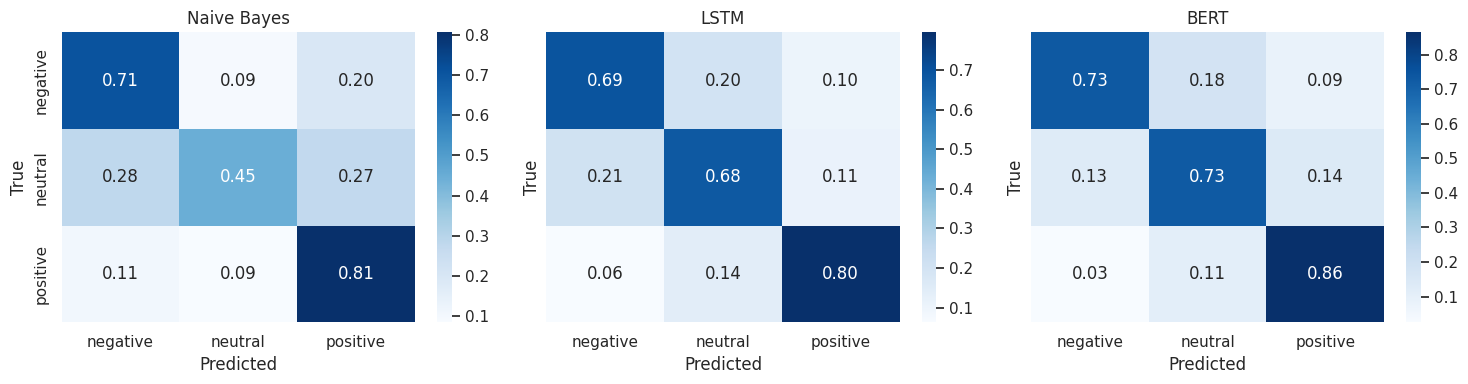

In [5]:

if not model_runs:
    display(Markdown("No runs available for confusion matrices."))
else:
    ordered_models = [m for m in model_order_lr if m in model_runs]
    n_models = len(ordered_models)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4), sharey=True)
    axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

    for ax, model in zip(axes, ordered_models):
        runs = model_runs[model]
        cms = []
        for run in runs:
            cm = confusion_matrix(run["y_true"], run["y_pred"], labels=class_order)
            row_sums = cm.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1
            cms.append(cm / row_sums)
        mean_cm = np.mean(cms, axis=0)
        sns.heatmap(
            mean_cm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax,
        )
        ax.set_title(model_name_map.get(model, model))
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    plt.show()



## 3.  **ROC Curves**

Plot performance across classification thresholds; a larger AUC means stronger ability to separate classes and is a good overall quality indicator.


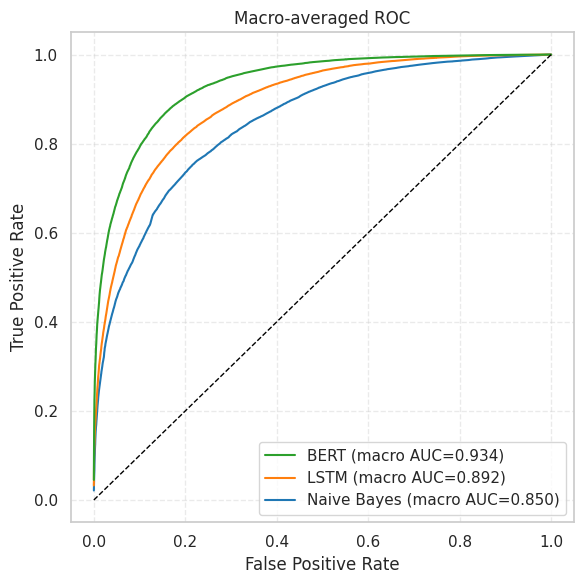

In [6]:

from sklearn.metrics import roc_curve, auc

prob_models = {m: [r for r in runs if r["probs"] is not None] for m, runs in model_runs.items()}
prob_models = {m: r for m, r in prob_models.items() if r}

if not prob_models:
    display(Markdown("Skipped ROC curves because no probability columns were found."))
else:
    plt.figure(figsize=(6, 6))
    for model in [m for m in model_order_lr if m in prob_models]:
        runs = prob_models[model]
        y_true = np.concatenate([r["y_true"] for r in runs])
        probs = np.concatenate([r["probs"] for r in runs], axis=0)
        y_true_bin = label_binarize(y_true, classes=class_order)

        fpr = {}
        tpr = {}
        for idx in range(len(class_order)):
            fpr[idx], tpr[idx], _ = roc_curve(y_true_bin[:, idx], probs[:, idx])
        all_fpr = np.unique(np.concatenate([fpr[idx] for idx in range(len(class_order))]))
        mean_tpr = np.zeros_like(all_fpr)
        for idx in range(len(class_order)):
            mean_tpr += np.interp(all_fpr, fpr[idx], tpr[idx])
        mean_tpr /= len(class_order)
        roc_auc = auc(all_fpr, mean_tpr)

        label = f"{model_name_map.get(model, model)} (macro AUC={roc_auc:.3f})"
        plt.plot(all_fpr, mean_tpr, label=label)

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-averaged ROC")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1])

    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout()
    plt.show()



## 4.  **Confidence Histograms**

Chart the distribution of predicted top probabilities to see whether the model is decisive (probabilities near 1.0) or hesitant (more spread out).


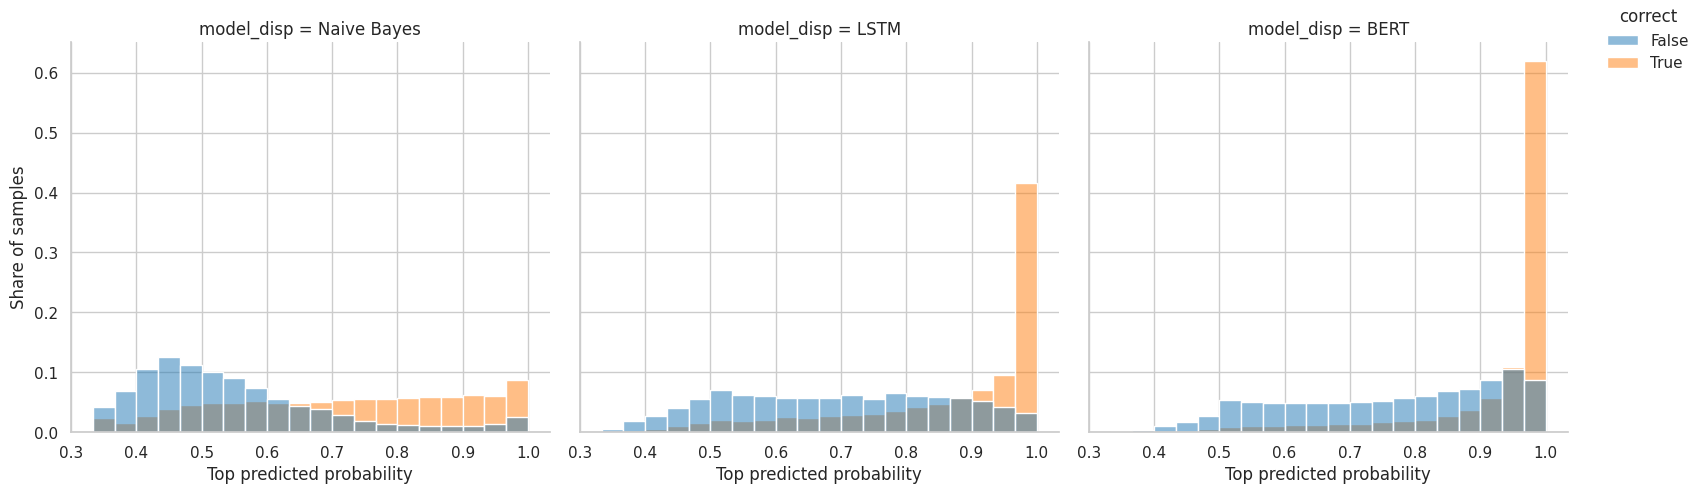

In [7]:

conf_rows = []
for model, runs in prob_models.items():
    for run in runs:
        max_prob = run["probs"].max(axis=1)
        correct = run["y_true"] == run["y_pred"]
        conf_rows.append(pd.DataFrame({
            "model": model,
            "max_prob": max_prob,
            "correct": correct,
        }))
conf_df = pd.concat(conf_rows, ignore_index=True) if conf_rows else pd.DataFrame()

if conf_df.empty:
    display(Markdown("Skipped confidence histograms because no probability columns were found."))
else:
    conf_df["model_disp"] = conf_df["model"].map(model_name_map).fillna(conf_df["model"])
    order = [model_name_map.get(m, m) for m in model_order_lr if m in conf_df["model"].unique()]
    g = sns.displot(
        conf_df,
        x="max_prob",
        hue="correct",
        col="model_disp",
        col_order=order,
        col_wrap=3,
        bins=20,
        stat="probability",
        common_norm=False,
        facet_kws={"sharex": True, "sharey": True},
    )
    g._legend.set_loc("upper left")
    g._legend.set_bbox_to_anchor((1, 1))
    g.set_axis_labels("Top predicted probability", "Share of samples")
    plt.tight_layout()
    plt.show()



## 5.  **Calibration Curves**

Check whether predicted probabilities are reliable (e.g., when the model predicts 80% confidence, is accuracy actually ~80%?), revealing overconfidence or underconfidence.


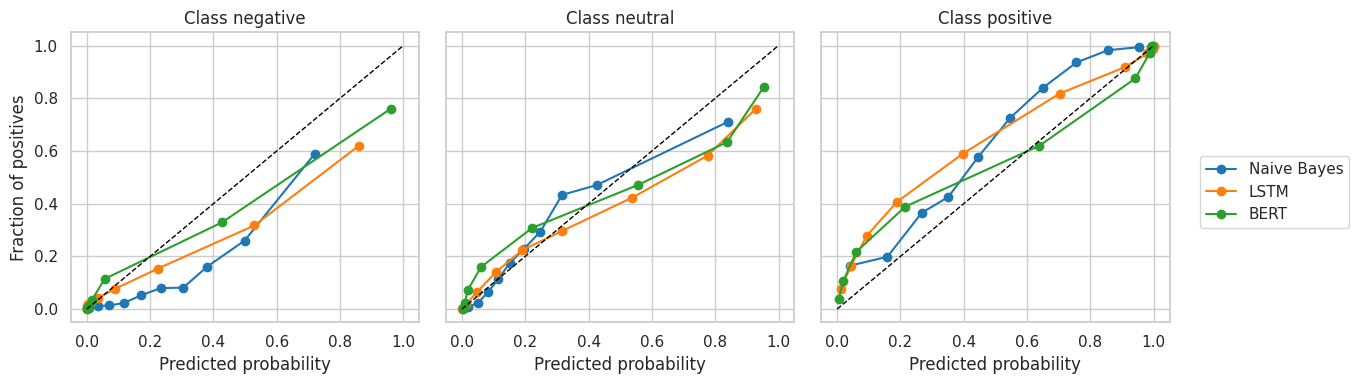

In [8]:
from sklearn.calibration import calibration_curve

if not prob_models:
    display(Markdown("Skipped calibration curves because no probability columns were found."))
else:
    fig, axes = plt.subplots(1, len(class_order), figsize=(4 * len(class_order), 4), sharey=True)
    axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

    for idx, cname in enumerate(class_names):
        ax = axes[idx]
        for model in [m for m in model_order_lr if m in prob_models]:
            runs = prob_models[model]
            y_true = np.concatenate([r["y_true"] for r in runs])
            probs = np.concatenate([r["probs"][:, idx] for r in runs])
            frac_pos, mean_pred = calibration_curve(
                (y_true == class_order[idx]).astype(int),
                probs,
                n_bins=10,
                strategy="quantile",
            )
            ax.plot(mean_pred, frac_pos, marker="o", label=model_name_map.get(model, model))
        ax.plot([0, 1], [0, 1], "k--", lw=1)
        ax.set_title(f"Class {cname}")
        ax.set_xlabel("Predicted probability")
        if idx == 0:
            ax.set_ylabel("Fraction of positives")

    handles, labels = axes[0].get_legend_handles_labels()
    for ax in axes:
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

    plt.tight_layout()
    plt.show()


## 6. Class-wise Performance
Compare F1-Score per class (Class 0, 1, 2) to spot whether any model is notably weak on specific classes (e.g., due to class imbalance).

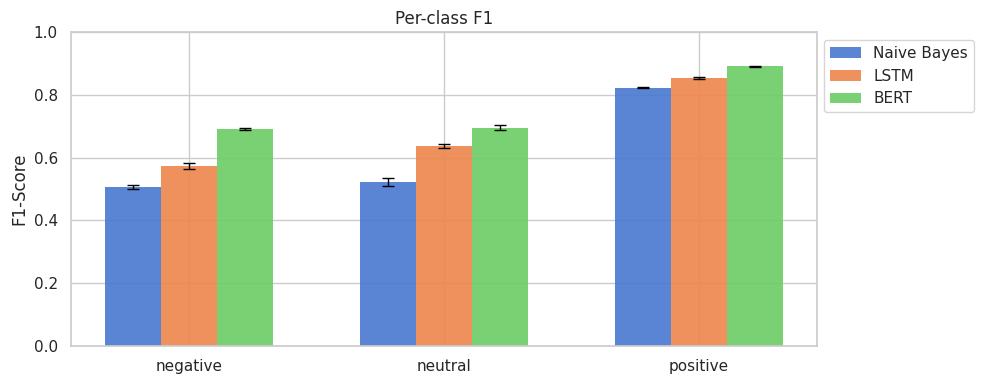

In [9]:
class_records = []
for model, runs in model_runs.items():
    for run in runs:
        per_class = f1_score(run["y_true"], run["y_pred"], average=None, labels=class_order, zero_division=0)
        for idx, score in enumerate(per_class):
            class_records.append({
                "model": model,
                "class": class_names[idx],
                "f1": score,
            })
class_df = pd.DataFrame(class_records)

if class_df.empty:
    display(Markdown("No runs available for class-wise performance."))
else:
    class_df["model_disp"] = class_df["model"].map(model_name_map).fillna(class_df["model"])
    order_models = [model_name_map.get(m, m) for m in model_order_lr if m in class_df["model"].unique()]
    order_classes = class_names

    agg = class_df.groupby(["class", "model_disp"]).agg(f1_mean=("f1", "mean"), f1_std=("f1", "std")).reset_index()
    class_pos = {c: i for i, c in enumerate(order_classes)}
    model_pos = {m: j for j, m in enumerate(order_models)}

    bar_width = 0.22
    x = np.arange(len(order_classes))
    palette = sns.color_palette("muted", n_colors=len(order_models))

    plt.figure(figsize=(10, 4))
    ax = plt.gca()
    for j, model_disp in enumerate(order_models):
        subset = agg[agg["model_disp"] == model_disp]
        means = [subset.loc[subset["class"] == c, "f1_mean"].iloc[0] if not subset.loc[subset["class"] == c].empty else np.nan for c in order_classes]
        stds = [subset.loc[subset["class"] == c, "f1_std"].iloc[0] if not subset.loc[subset["class"] == c].empty else 0 for c in order_classes]
        positions = x + (j - (len(order_models)-1)/2) * bar_width
        ax.bar(positions, means, width=bar_width, color=palette[j], label=model_disp, edgecolor="none", alpha=0.9)
        ax.errorbar(positions, means, yerr=stds, fmt="none", ecolor="black", capsize=4, lw=1)

    ax.set_xticks(x)
    ax.set_xticklabels(order_classes)
    ax.set_ylabel("F1-Score")
    ax.set_title("Per-class F1")
    ax.set_ylim(0, 1)
    ax.legend(title=None, bbox_to_anchor=(1, 1), loc="upper left")
    plt.tight_layout()
    plt.show()



## 7.  **Accuracy vs Text Length**

Group test samples by length and observe how comment length affects accuracy—often used to see if models like LSTM/BERT handle longer texts better than traditional models.

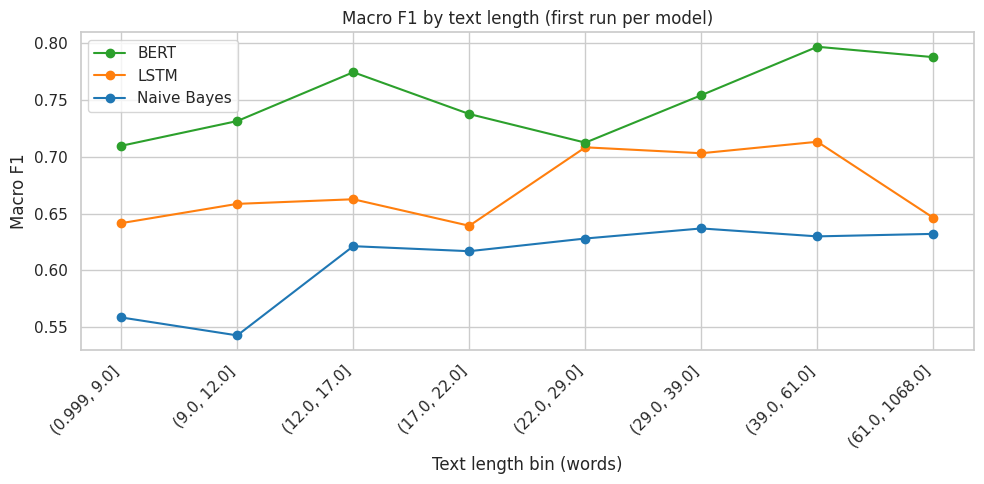

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

plotted = False
for model in [m for m in model_order_lr if m in model_runs]:
    files = sorted((base_dir / model).glob("*.csv"))
    if not files:
        continue
    df = pd.read_csv(files[0], usecols=["comment", "true_label", "pred_label"])
    df["text_len"] = df["comment"].astype(str).str.split().str.len()

    df["len_bin"] = pd.qcut(df["text_len"], q=8, duplicates="drop")
    df = df.dropna(subset=["len_bin"])

    f1_by_bin = (
        df.groupby("len_bin", observed=False, group_keys=False)
          .apply(lambda g: f1_score(g["true_label"], g["pred_label"],
                                    average="macro", labels=class_order, zero_division=0),
                 include_groups=False)
          .dropna()
    )

    x_labels = [str(b) for b in f1_by_bin.index]
    ax.plot(x_labels, f1_by_bin.values, marker="o", label=model_name_map.get(model, model))
    plotted = True

if not plotted:
    display(Markdown("No runs available for F1 vs text length."))
else:
    ax.set_xlabel("Text length bin (words)")
    ax.set_ylabel("Macro F1")
    ax.set_title("Macro F1 by text length (first run per model)")
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1])
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
